In [1]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Data Preparation

In [2]:
from datetime import datetime
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_theme()

## Historical Data Import

In [3]:
historical = pd.read_csv('./data/monterey_historical.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318243 entries, 0 to 2318242
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   field_id     object        
 1   crop         int64         
 2   time         datetime64[ns]
 3   actual_et    float64       
 4   actual_eto   float64       
 5   actual_etof  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 106.1+ MB


## Forecast Table Build

In [4]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"data/forecasts/monterey/").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   field_id          object        
 1   crop              int64         
 2   time              datetime64[ns]
 3   expected_et       float64       
 4   expected_eto      float64       
 5   expected_etof     float64       
 6   forecasting_date  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 447.8+ MB


## Main Data Table compilation

In [5]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]
dt = dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt

,forecasting_date,field_id,crop,time,actual_et,actual_eto,actual_etof,expected_et,expected_eto,expected_etof
0,2024-07-29,CA_244000,47,2024-01-01,0.718,1.103,0.650,0.718,1.103,0.650
1,2024-07-29,CA_244000,47,2024-01-02,0.668,1.018,0.656,0.668,1.018,0.656
2,2024-07-29,CA_244000,47,2024-01-03,1.403,2.122,0.661,1.403,2.122,0.661
3,2024-07-29,CA_244000,47,2024-01-04,1.698,2.546,0.667,1.698,2.546,0.667
4,2024-07-29,CA_244000,47,2024-01-05,1.027,1.528,0.672,1.027,1.528,0.672
...,...,...,...,...,...,...,...,...,...,...
8384689,2024-01-01,CA_251078,61,2024-01-05,0.339,1.292,0.262,0.175,1.650,0.106
8384690,2024-01-01,CA_251078,61,2024-01-04,0.461,1.846,0.250,0.184,1.714,0.108
8384691,2024-01-01,CA_251078,61,2024-01-03,0.307,1.292,0.237,0.187,1.708,0.110
8384692,2024-01-01,CA_251078,61,2024-01-02,0.104,0.462,0.225,0.184,1.643,0.113


### Add geographical data

In [6]:
# Add additional data to the data table
monterey_points = pd.read_csv("./Monterey.csv", low_memory=False).set_index("OPENET_ID").rename_axis("field_id")

# Expand .geo column into lon, lat columns
monterey_geo = (monterey_points[".geo"]
                .apply(lambda x: pd.Series(dict(json.loads(x))))['coordinates']
                .apply(lambda x: pd.Series(list(x), index=['longitude', 'latitude'])))
monterey_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 739 entries, CA_253578 to CA_251078
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  739 non-null    float64
 1   latitude   739 non-null    float64
dtypes: float64(2)
memory usage: 17.3+ KB


In [7]:
dt = dt.join(monterey_geo, how="left", on=["field_id"], validate="many_to_one")
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  longitude         float64       
 11  latitude          float64       
dtypes: datetime64[ns](2), float64(8), int64(1), object(1)
memory usage: 767.6+ MB


### Add USDA crop data

In [8]:
# Add crop data
cdl_codes = pd.read_csv("cdl_codes.csv", low_memory=False).set_index("Codes")

dt = dt.join(cdl_codes, how="left", on="crop", validate="many_to_many")
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8384694 entries, 0 to 8384693
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  longitude         float64       
 11  latitude          float64       
 12  Class_Names       object        
 13  ESRI_Red          int64         
 14  ESRI_Green        int64         
 15  ESRI_Blue         int64         
 16  Erdas_Red         float64       
 17  Erdas_Green       float64       
 18  Erdas_Blue        float64       
dtypes: datetime64[ns](2), float64(11), int64(4), object(2)
memory usage: 1.2+ GB


### List of identifiers

In [9]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

## Field Metadata Table

In [121]:
field_metadata = pd.read_json('./data/geo/field_metadata.json')
field_metadata.head()

,field_id,hectares,crop_2016,crop_2017,crop_2018,crop_2019,crop_2020,crop_2021,crop_2022,mod_date
0,6244000,263.816,33,47,33,47,47,47,47,2020-08-17
1,6244018,164.326,23,47,2,47,47,47,47,2020-08-17
2,6244025,178.508,23,47,2,47,47,47,47,2020-08-17
3,6244035,125.078,2,47,54,47,47,47,47,2020-08-17
4,6244053,126.523,25,47,61,61,61,61,61,2020-08-17


# Analysis

## Helpers
Below are functions that are being used to calculate data and generate plots.

The tables below are also calculated prior to speed up metric calculations.

### Average ET/ETo/ETof for 2024
This table will be used as a reference for any metric and plot calculations

In [10]:
avgs_table = dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
avgs_table.head()

,,actual_et,actual_eto,actual_etof
field_id,crop,,,
CA_244000,47,2.824991,3.689372,0.746786
CA_244018,47,1.754977,3.235660,0.509930
CA_244025,47,2.048874,3.252205,0.657567
CA_244035,69,1.602502,2.883186,0.576400
CA_244053,47,1.514633,3.235660,0.462088


### Climatology Reference
The table below records the average conditions for each field for each day of the year.

In [11]:
# Create a column for day of year
historical['doy'] = historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
climatology_table = historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
climatology_table

actual_et  actual_eto  actual_etof
field_id  crop doy                                    
CA_244000 47   1     0.906778    1.291889     0.687889
               2     0.921222    1.310778     0.693444
               3     0.994778    1.423778     0.698444
               4     1.157778    1.697333     0.688556
               5     1.099111    1.556000     0.691889
...                       ...         ...          ...
CA_420924 68   362   0.813125    1.293625     0.643375
               363   0.781875    1.202875     0.658250
               364   0.750250    1.146250     0.673250
               365   0.570625    0.851125     0.690500
               366   0.728000    1.089500     0.640000

[270474 rows x 3 columns]

### calculate_metrics
This function calculate the mean absolute error (mae), root mean squared error (rmse), mean forecast error (bias), correlation coefficient (R), and skill score.

MAE, RMSE, and R are calculated using sklearn's metric module.

Skill score is calculated by getting the climatology for each field within the input's date range.
* Negative skill scores indicate the MSE for forecast is larger than the MSE for climatology
* Positive skill scores indicate otherwise

The function is very flexible given the data is formatted appropriately. It has the option of enabling normalization which is based on the average specified variable (ET, ETo, or ETof) throughout that field's historical data.

In [118]:
def calculate_metrics(data: pd.DataFrame, *, historical: pd.DataFrame, actual: str, expected: str, normalize: bool = False) -> pd.Series:
	# Calculate error metrics
	mae: float = mean_absolute_error(data[actual], data[expected])
	forecast_mse: float = mean_squared_error(data[actual], data[expected])
	rmse: float = np.sqrt(forecast_mse)

    # Correlation Coefficient (R)
	cor = data[actual].corr(data[expected]).astype(float)
    
    # Mean Forecast Bias determines if the forecast is overshooting or undershooting.
    # Greater positive number indicates overshooting.
	bias: float = np.mean(data[expected] - data[actual])

	# Climatology uses the mean actual variable for that time of year using historical data.
	field = data.head(1).squeeze()
	start_date = data['time'].min().dayofyear
	end_date = data['time'].max().dayofyear

	# Filter the climatology reference
	field_mask = (climatology_table.index.get_level_values(0) == field['field_id'])
	crop_mask = (climatology_table.index.get_level_values(1) == field['crop'])
	date_mask = ((climatology_table.index.get_level_values(2) >= start_date) & (climatology_table.index.get_level_values(2) <= end_date))

	climatology = climatology_table[field_mask & crop_mask & date_mask][actual]

	climatology_mse = mean_squared_error(data[actual], climatology)

	# Positive skill score indicates the error in climatology is greater than forecast.
    # This means that forecast is outperforming climatology.
	skill_score = 1 - (forecast_mse / climatology_mse)

	if normalize:
		avg: float = avgs_table[avgs_table.index.get_level_values(0) == field['field_id']][actual].values[0]

		mae: float = mae.astype(float) / avg.astype(float)
		rmse = np.sqrt(forecast_mse.astype(float) / avg.astype(float))
		bias = bias.astype(float) / avg.astype(float)

	return pd.Series({
		'mae': mae.round(2),
		'rmse': rmse.round(2),
		'corr': cor.round(2),
		'bias': bias.round(2),
		'skill_score': skill_score.round(2)
	})

### eval_metrics
This function evaluates the metrics for each variable. The output is a DataFrame containing the metrics with a column specifying which variable (ET, ETo, ETof)

In [13]:
def eval_metrics(table: pd.DataFrame, by=['field_id', 'crop'], **kwargs) -> pd.DataFrame:
    metrics_table = pd.DataFrame(columns=["field_id", "variable", "crop", "mae", "rmse", "corr", "bias", "skill_score"])

    et_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_et", "expected_et"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_et', expected='expected_et', **kwargs).reset_index()
    et_metrics['variable'] = "ET"

    metrics_table = pd.concat([et_metrics.astype(metrics_table.dtypes), metrics_table.astype(et_metrics.dtypes)], ignore_index=True)

    eto_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_eto", "expected_eto"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_eto', expected='expected_eto', **kwargs).reset_index()
    eto_metrics['variable'] = "ETo"
    metrics_table = pd.concat([eto_metrics.astype(metrics_table.dtypes), metrics_table.astype(eto_metrics.dtypes)], ignore_index=True)

    etof_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_etof", "expected_etof"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_etof', expected='expected_etof', **kwargs).reset_index()
    etof_metrics['variable'] = "ETof"
    metrics_table = pd.concat([etof_metrics.astype(metrics_table.dtypes), metrics_table.astype(etof_metrics.dtypes)], ignore_index=True)

    return metrics_table

### timeseries_plot
This plot function is designed to easily showcase actual vs forecast data. It is also flexible in that it can show a singular line if a second column is not specified. This is used to show the metrics over time.

In [66]:
def timeseries_plot(data, *, x, y_a, y_b=None, title='', ylabel, xlabel, errorbar=None, figsize=(6, 4), as_percent=False, **kwargs):
    figure, xa = plt.subplots(figsize=figsize)
    xb = xa.twinx() if y_b else None

    if y_a:
        first_line = sns.lineplot(data, x=x, y=y_a, ax=xa, errorbar=errorbar, **kwargs)
    if y_b:
        second_line = sns.lineplot(data, x=x, y=y_b, ax=xb, linestyle='dashed', errorbar=None, legend=False, **kwargs)

    # Remove y axis label for the second line
    if xb: xb.set_ylabel('')
    # first_line is the main subplot so metadata should get changed for that one
    # Relabel y axis
    if ylabel: xa.set_ylabel(ylabel)
    if as_percent: xa.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # Relabel x axis
    if xlabel: xa.set_xlabel(xlabel)
    # Rotate x-time axis
    first_line.tick_params(axis='x', rotation=90)
    # Relocate legend to be outside subplot
    try: sns.move_legend(first_line, "upper left", bbox_to_anchor=(1.25, 1))
    except: pass
    # Set title if specified
    first_line.set_title(title)

    return (figure, xa, xb)

### timeseries_rel
This plot function utilizes the seaborn relplot method to create grids of plots. Particularly useful for showing distribution on one cell.

In [65]:
def timeseries_rel(data, *, y, type='rel', col, row=None, hue=None, kind='line', title='', ylabel='', sharey=True, errorbar=None, **kwargs):
    match type:
        case 'rel':
            rel = sns.relplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'dis': 
            rel = sns.displot(data=data, x=y, col=col, row=row, hue=hue, kind=kind, **kwargs)
        case 'cat':
            rel = sns.catplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'lm':
            rel = sns.lmplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case _:
            raise Exception('Not a valid plot type.')

    rel.set_xlabels('Forecasting Date')
    # Relabel y axis
    if ylabel: rel.set_ylabels(ylabel)
    # Relabel x axis
    rel.tick_params(axis='x', rotation=90)
    plt.suptitle(title, y=1.02);

    return rel

### trim_extremes
Trim the edges of the DataFrame along provided columns with provided threshold.

In [31]:
def trim_extremes(data, *, cols, threshold):
    # Convert single input as list
    if type(cols) is not list:
        cols = [cols]
    # Go through each column. Rank the values by % then remove the extremes.
    for c in cols:
        data[f'{c}_pct'] = data[c].rank(pct=True)
        data.drop(index=data[(data[f'{c}_pct'] <= threshold) | (data[f'{c}_pct'] >= (1 - threshold))].index, inplace=True)
        data.drop(columns=f'{c}_pct', inplace=True)
    data.drop(columns='forecasting_date', inplace=True)
    return data

## Calculation

In [17]:
analysis_end_date = historical['time'].max()

Est. run time: 21m

In [34]:
metrics_norm = pd.read_csv('data/metrics/monterey_metrics_normalized.csv').drop(['level_1'], axis=1)
metrics_norm['forecasting_date'] = pd.to_datetime(metrics_norm['forecasting_date'])

In [33]:
# metrics_norm = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < analysis_end_date)]
#                 .groupby(['forecasting_date'])[list(dt.columns)]
#                 .apply(eval_metrics, normalize=True))
# metrics_norm.reset_index().to_csv('data/metrics/monterey_metrics_normalized.csv', index=False)

In [35]:
metrics_norm = metrics_norm.groupby(['forecasting_date'])[list(metrics_norm.columns)].apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.02)
metrics_norm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56022 entries, (Timestamp('2024-01-01 00:00:00'), 1) to (Timestamp('2024-07-29 00:00:00'), 68726)
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   field_id     56022 non-null  object 
 1   crop         56022 non-null  int64  
 2   mae          56022 non-null  float64
 3   rmse         56022 non-null  float64
 4   corr         55479 non-null  float64
 5   bias         56022 non-null  float64
 6   skill_score  56022 non-null  float64
 7   variable     56022 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


In [36]:
metrics_norm.head()

field_id  crop   mae  rmse  corr  bias  skill_score  \
forecasting_date                                                           
2024-01-01       1  CA_244018    47  0.60  0.50 -0.03  0.32         0.42   
                 2  CA_244025    47  0.28  0.27  0.62 -0.09         0.04   
                 3  CA_244035    69  0.25  0.24  0.59 -0.19        -0.41   
                 4  CA_244053    47  0.38  0.31 -0.08  0.02         0.48   
                 5  CA_244054    69  0.21  0.22  0.48 -0.14        -0.30   

                   variable  
forecasting_date             
2024-01-01       1     ETof  
                 2     ETof  
                 3     ETof  
                 4     ETof  
                 5     ETof

### Crop metrics

In [38]:
crop_metrics = pd.read_csv('data/metrics/montery_crop_metrics.csv', low_memory=False).drop(columns=['crop.1', 'Unnamed: 2'])
crop_metrics['forecasting_date'] = pd.to_datetime(crop_metrics['forecasting_date'])

In [37]:
# crop_metrics = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < analysis_end_date)]
#                 .groupby(by=['forecasting_date', 'crop'])[list(dt.columns)]
#                 .apply(eval_metrics, normalize=True))

In [39]:
crop_metrics = crop_metrics.groupby(['forecasting_date'])[list(crop_metrics.columns)].apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.02)
crop_metrics.head(10)

crop   field_id   mae  rmse  corr  bias  skill_score  \
forecasting_date                                                            
2024-01-01       0     37  CA_246012  0.28  0.30  0.29  0.19        -0.10   
                 1     37  CA_248155  0.32  0.31  0.73 -0.12         0.49   
                 2     37  CA_248877  0.30  0.28  0.23  0.12        -0.09   
                 4     37  CA_246012  0.21  0.49  0.85  0.09         0.90   
                 6     37  CA_248877  0.22  0.54  0.82  0.10         0.88   
                 7     37  CA_256027  0.22  0.46  0.82  0.12         0.87   
                 8     37  CA_246012  0.51  0.92  0.57  0.39         0.46   
                 9     37  CA_248155  0.39  0.75  0.42  0.08         0.47   
                 10    37  CA_248877  0.44  0.80  0.46  0.29         0.37   
                 11    37  CA_256027  0.20  0.43  0.86  0.01         0.91   

                    variable  
forecasting_date              
2024-01-01       0      ETof  
                 1      ETof  
                 2      ETof  
                 4       ETo  
                 6       ETo  
                 7       ETo  
                 8        ET  
                 9        ET  
                 10       ET  
                 11       ET

# Visualization

## Metric Correlation

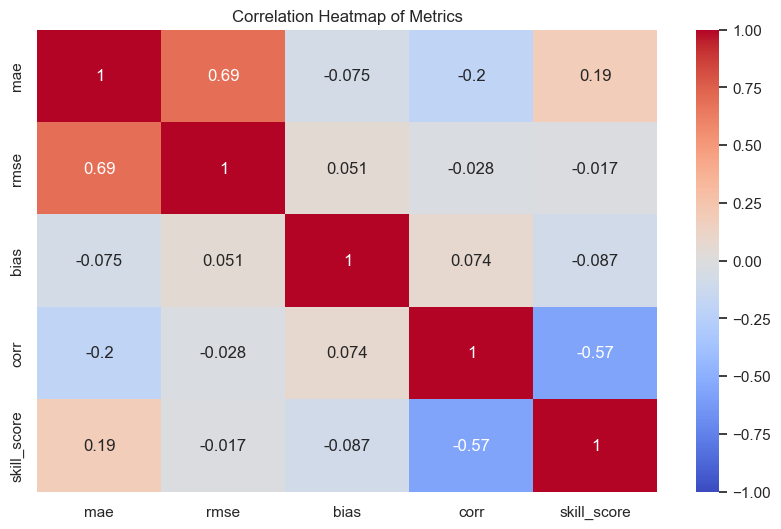

In [28]:
plt.figure(figsize=(10, 6))
metrics = ['mae', 'rmse', 'bias', 'corr', 'skill_score']
corr_matrix = metrics_norm[metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Metrics')
plt.show()

## Distribution of Metrics

In [40]:
# First reshape data from wide-form to long-form
metrics_long = metrics_norm.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'rmse', 'bias', 'corr', 'skill_score'], var_name='stat')
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280110 entries, 0 to 280109
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  280110 non-null  datetime64[ns]
 1   field_id          280110 non-null  object        
 2   crop              280110 non-null  int64         
 3   variable          280110 non-null  object        
 4   stat              280110 non-null  object        
 5   value             279567 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 12.8+ MB


## KDE Distribution 

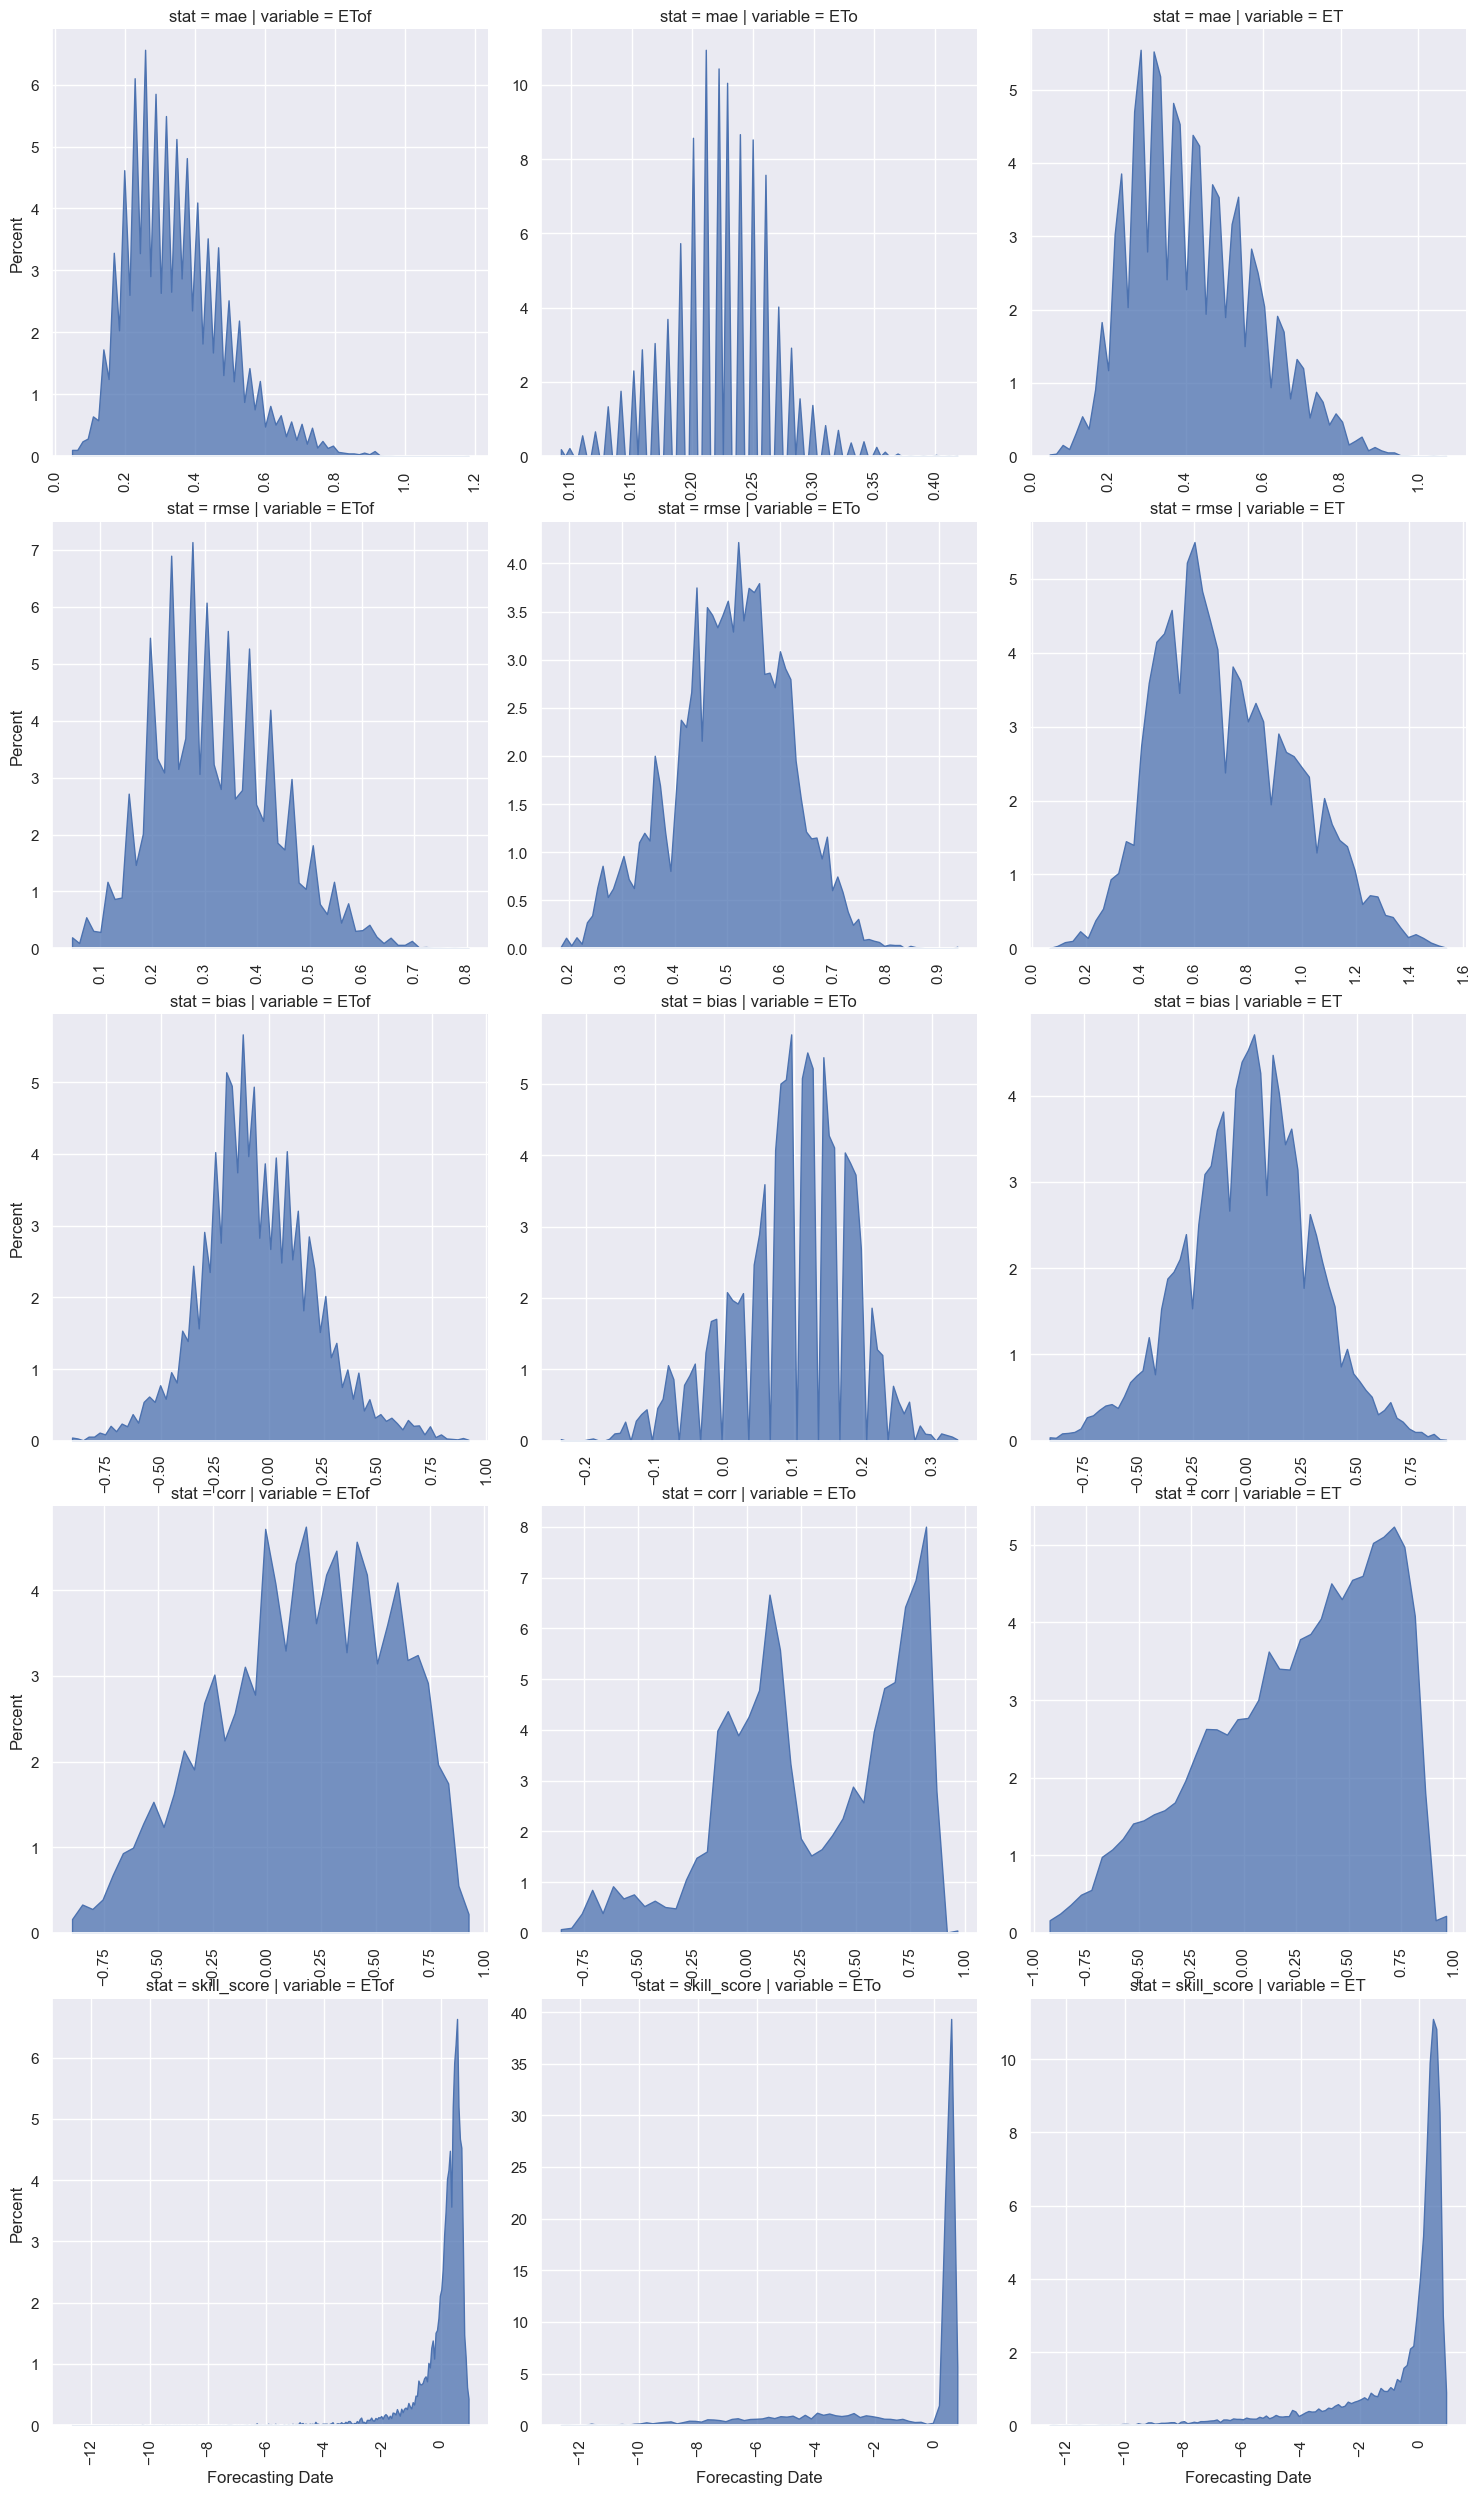

In [44]:
timeseries_rel(metrics_long, type='dis', kind='hist', stat='percent', 
               y='value', col='variable', row='stat', facet_kws={'sharey': False, 'sharex': False},
               common_norm=False, common_bins=False, element='poly',
               title='PDF Distribution of Metrics by Variable');

## Boxplot Distribution

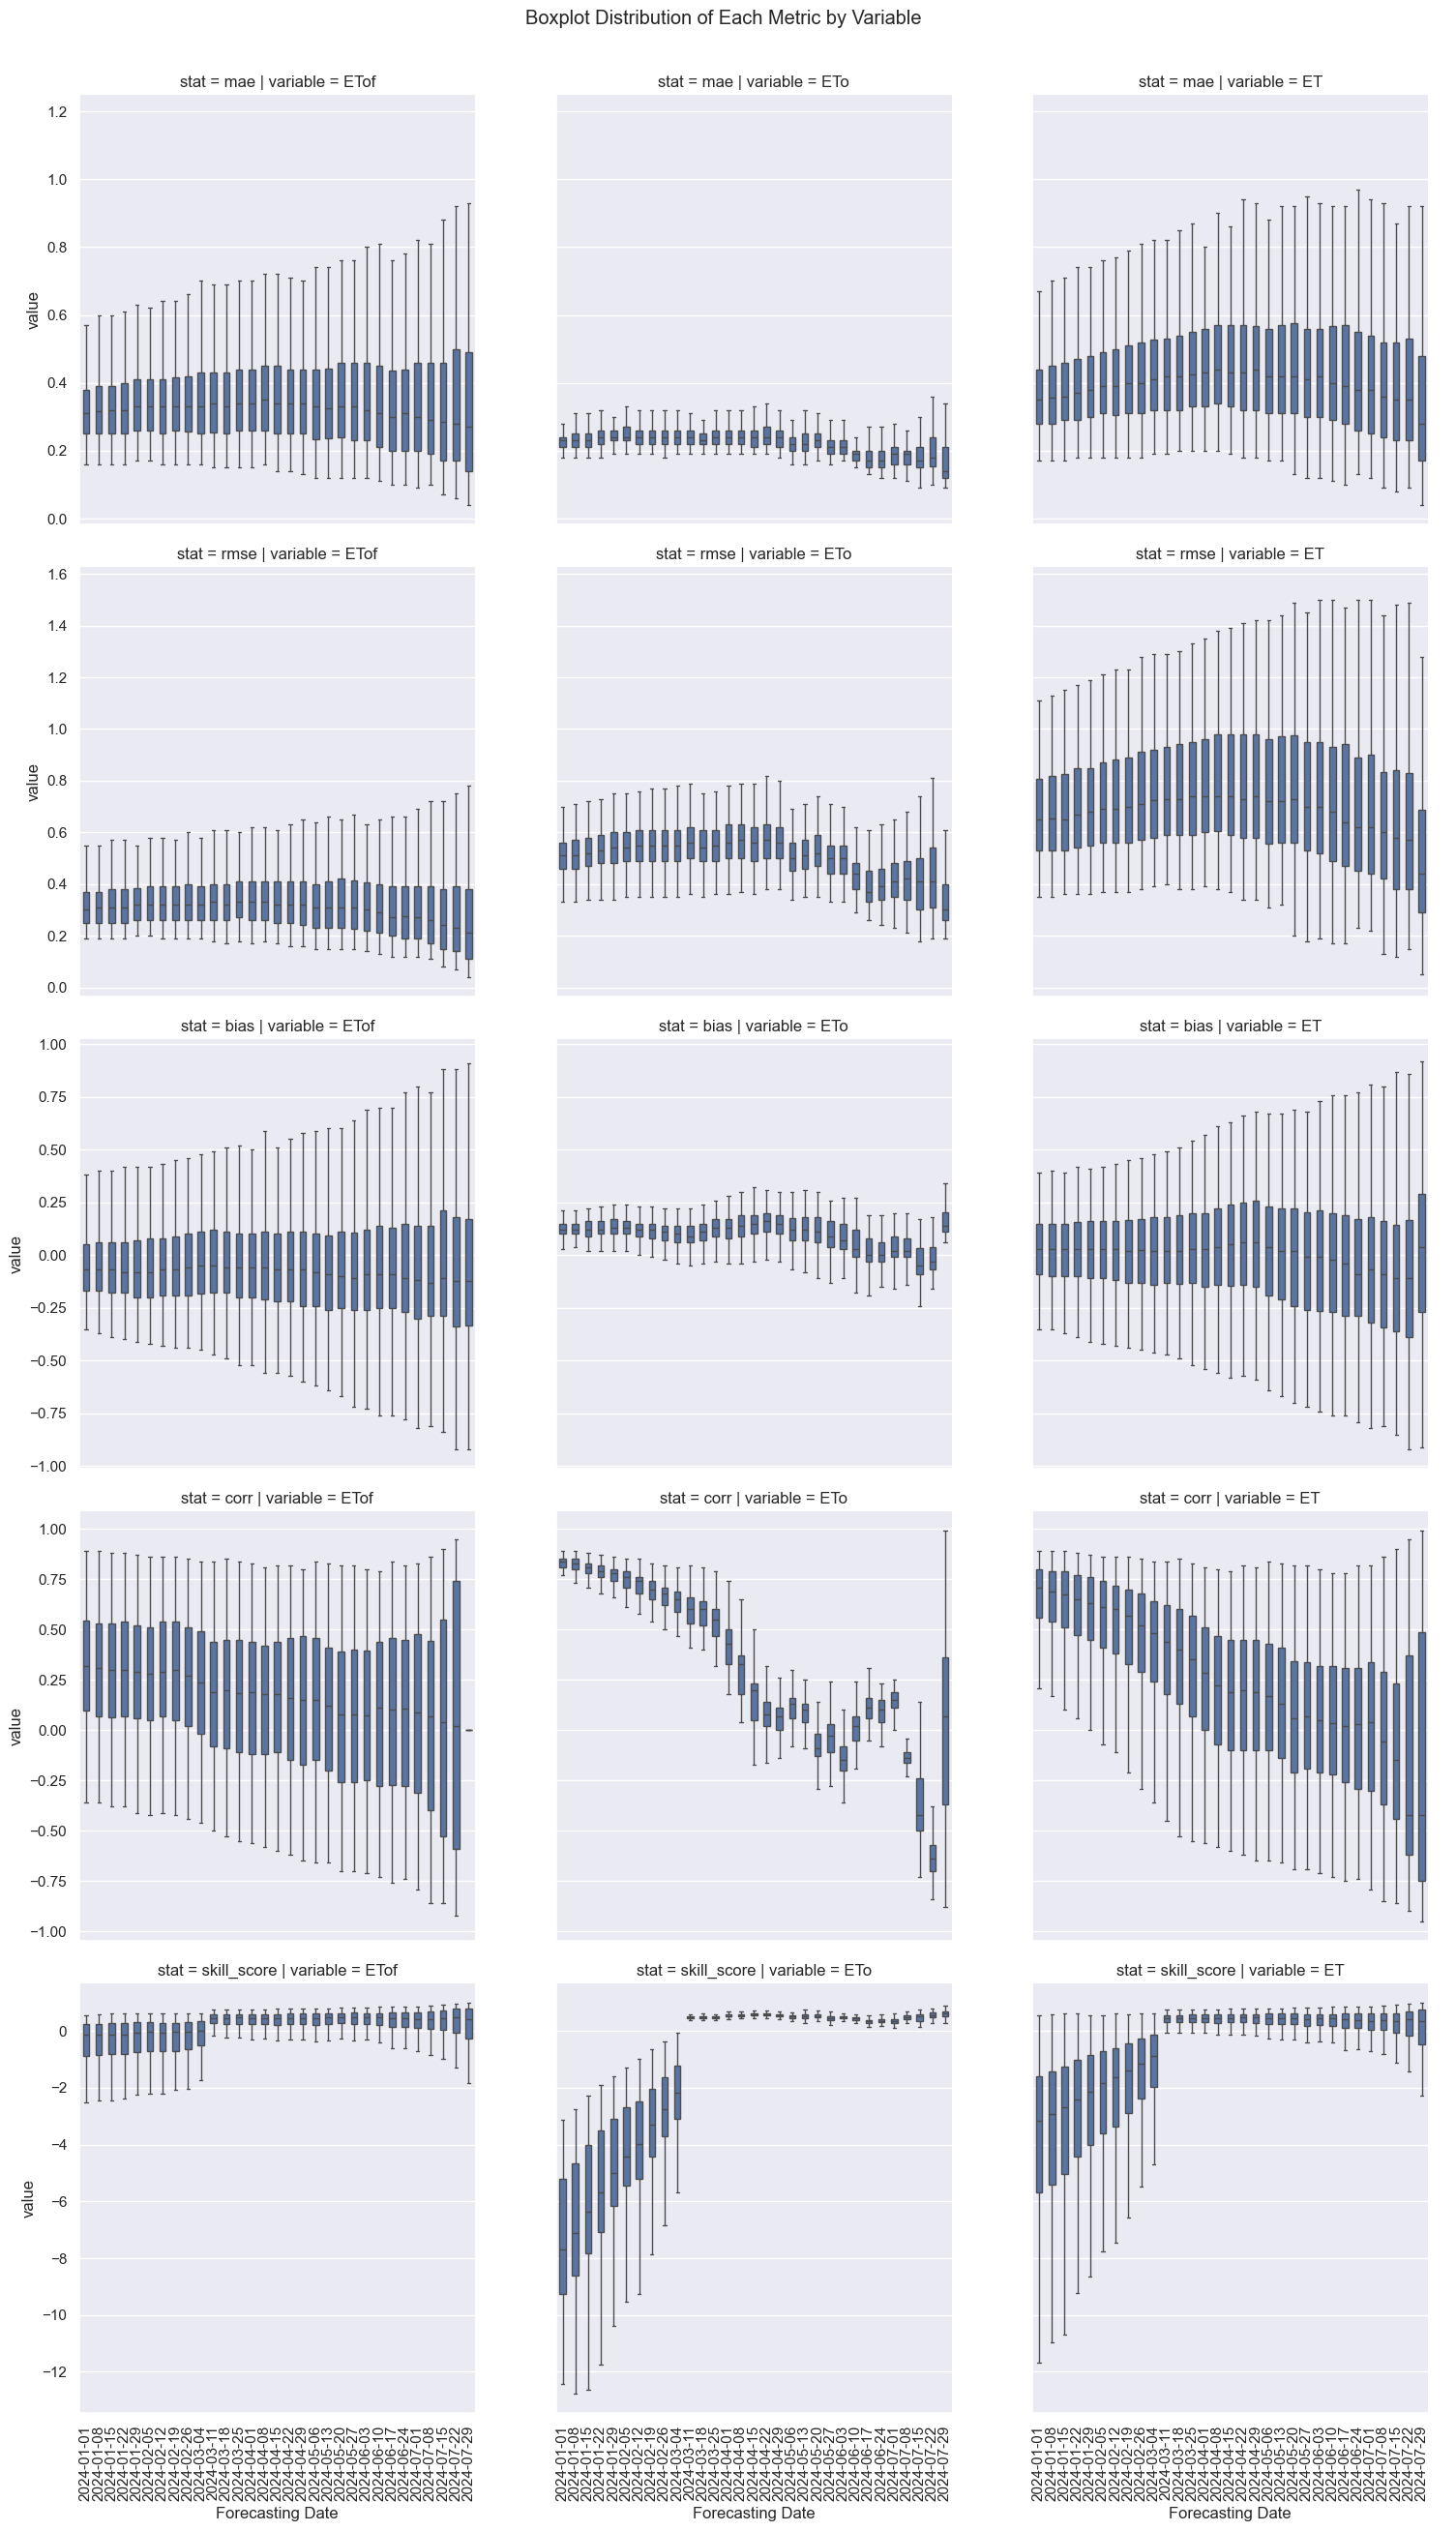

In [117]:
# Make vertical
g = sns.catplot(data=metrics_long, kind='box',
                y='value', x='forecasting_date', col='variable', row='stat', 
                sharey='row', width=0.5, errorbar='sd',
                flierprops=dict(markersize=0)
               );
g.set_xlabels('Forecasting Date');
# Relabel x axis
g.tick_params(axis='x', rotation=90);
plt.suptitle("Boxplot Distribution of Each Metric by Variable", y=1.02);

## Metric Distrbution by Standard Deviation

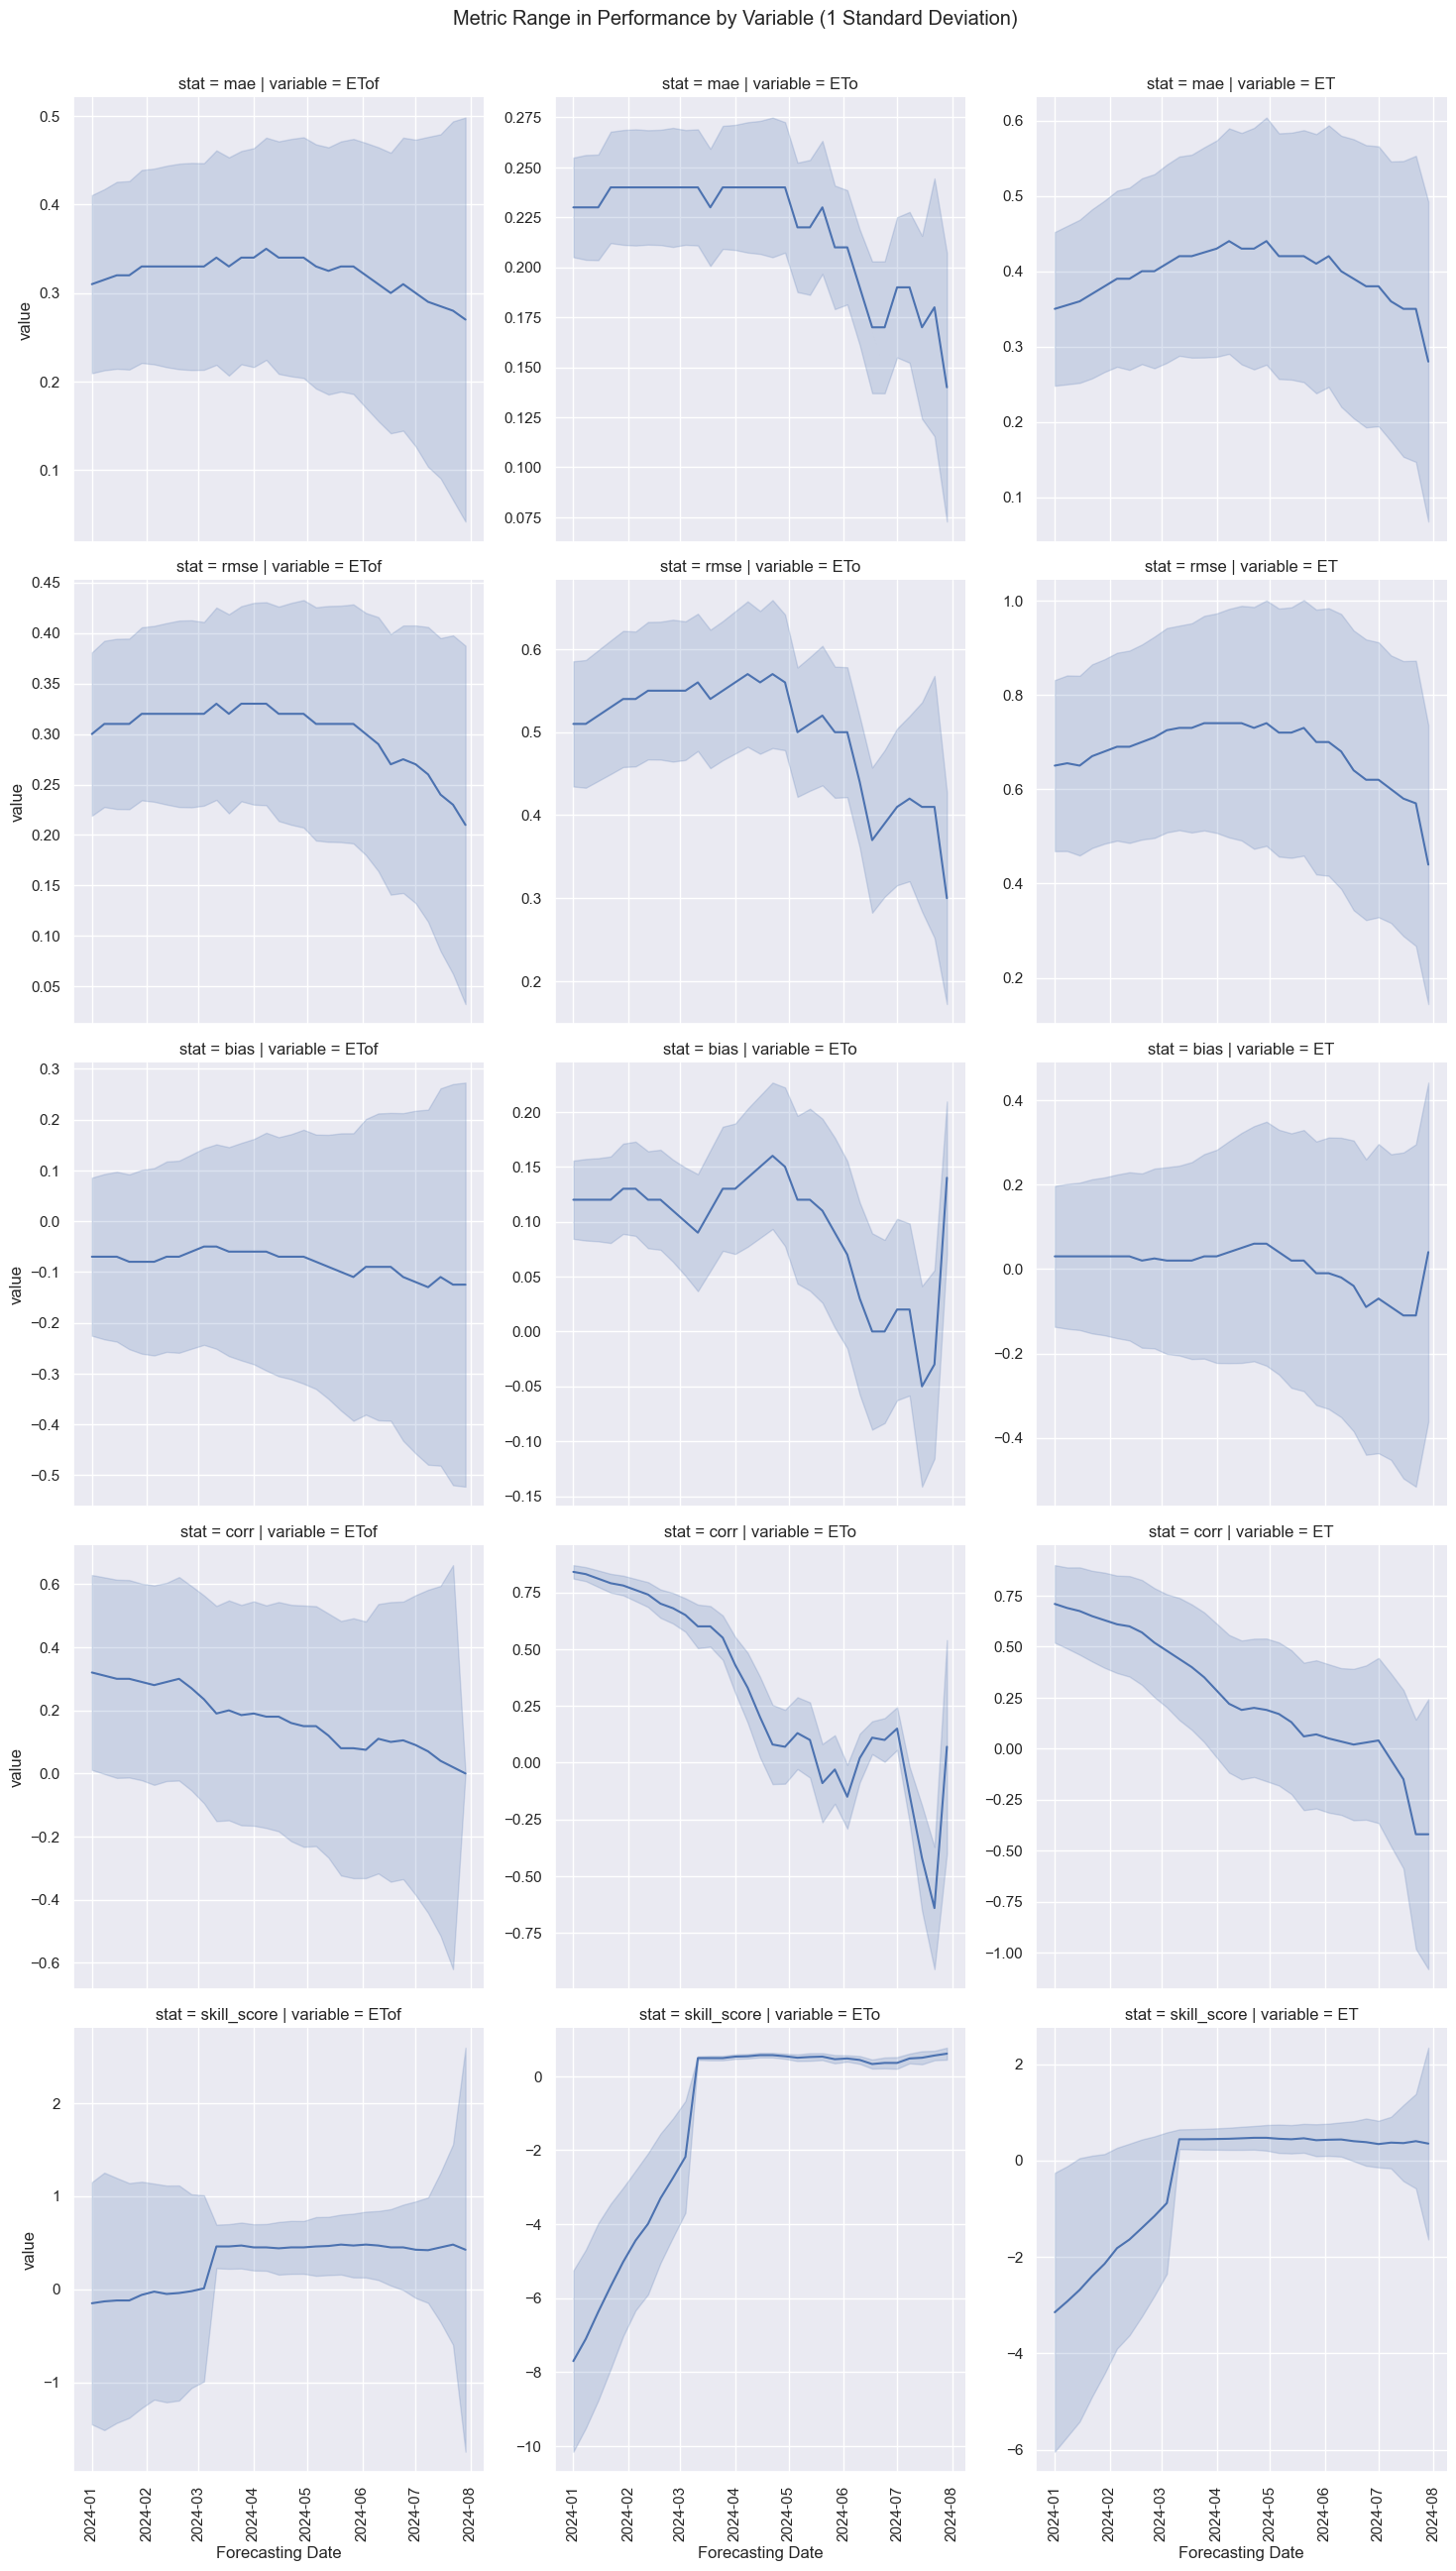

In [67]:
timeseries_rel(metrics_long, row='stat', col='variable', y='value',
              errorbar='sd', estimator=np.median,
               facet_kws={'sharey': False, 'sharex': True},
              title="Metric Range in Performance by Variable (1 Standard Deviation)");

## Crop Metrics

In [46]:
# Reappend class names of crops for better readability in plots.
metrics_long = metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")

In [84]:
top_crops = (dt['crop'].value_counts() / len(forecast_dates) / 366)[:3]

In [87]:
crop_plotter = metrics_long[metrics_long['crop'].isin(top_crops.index)]

### Probability Distributions

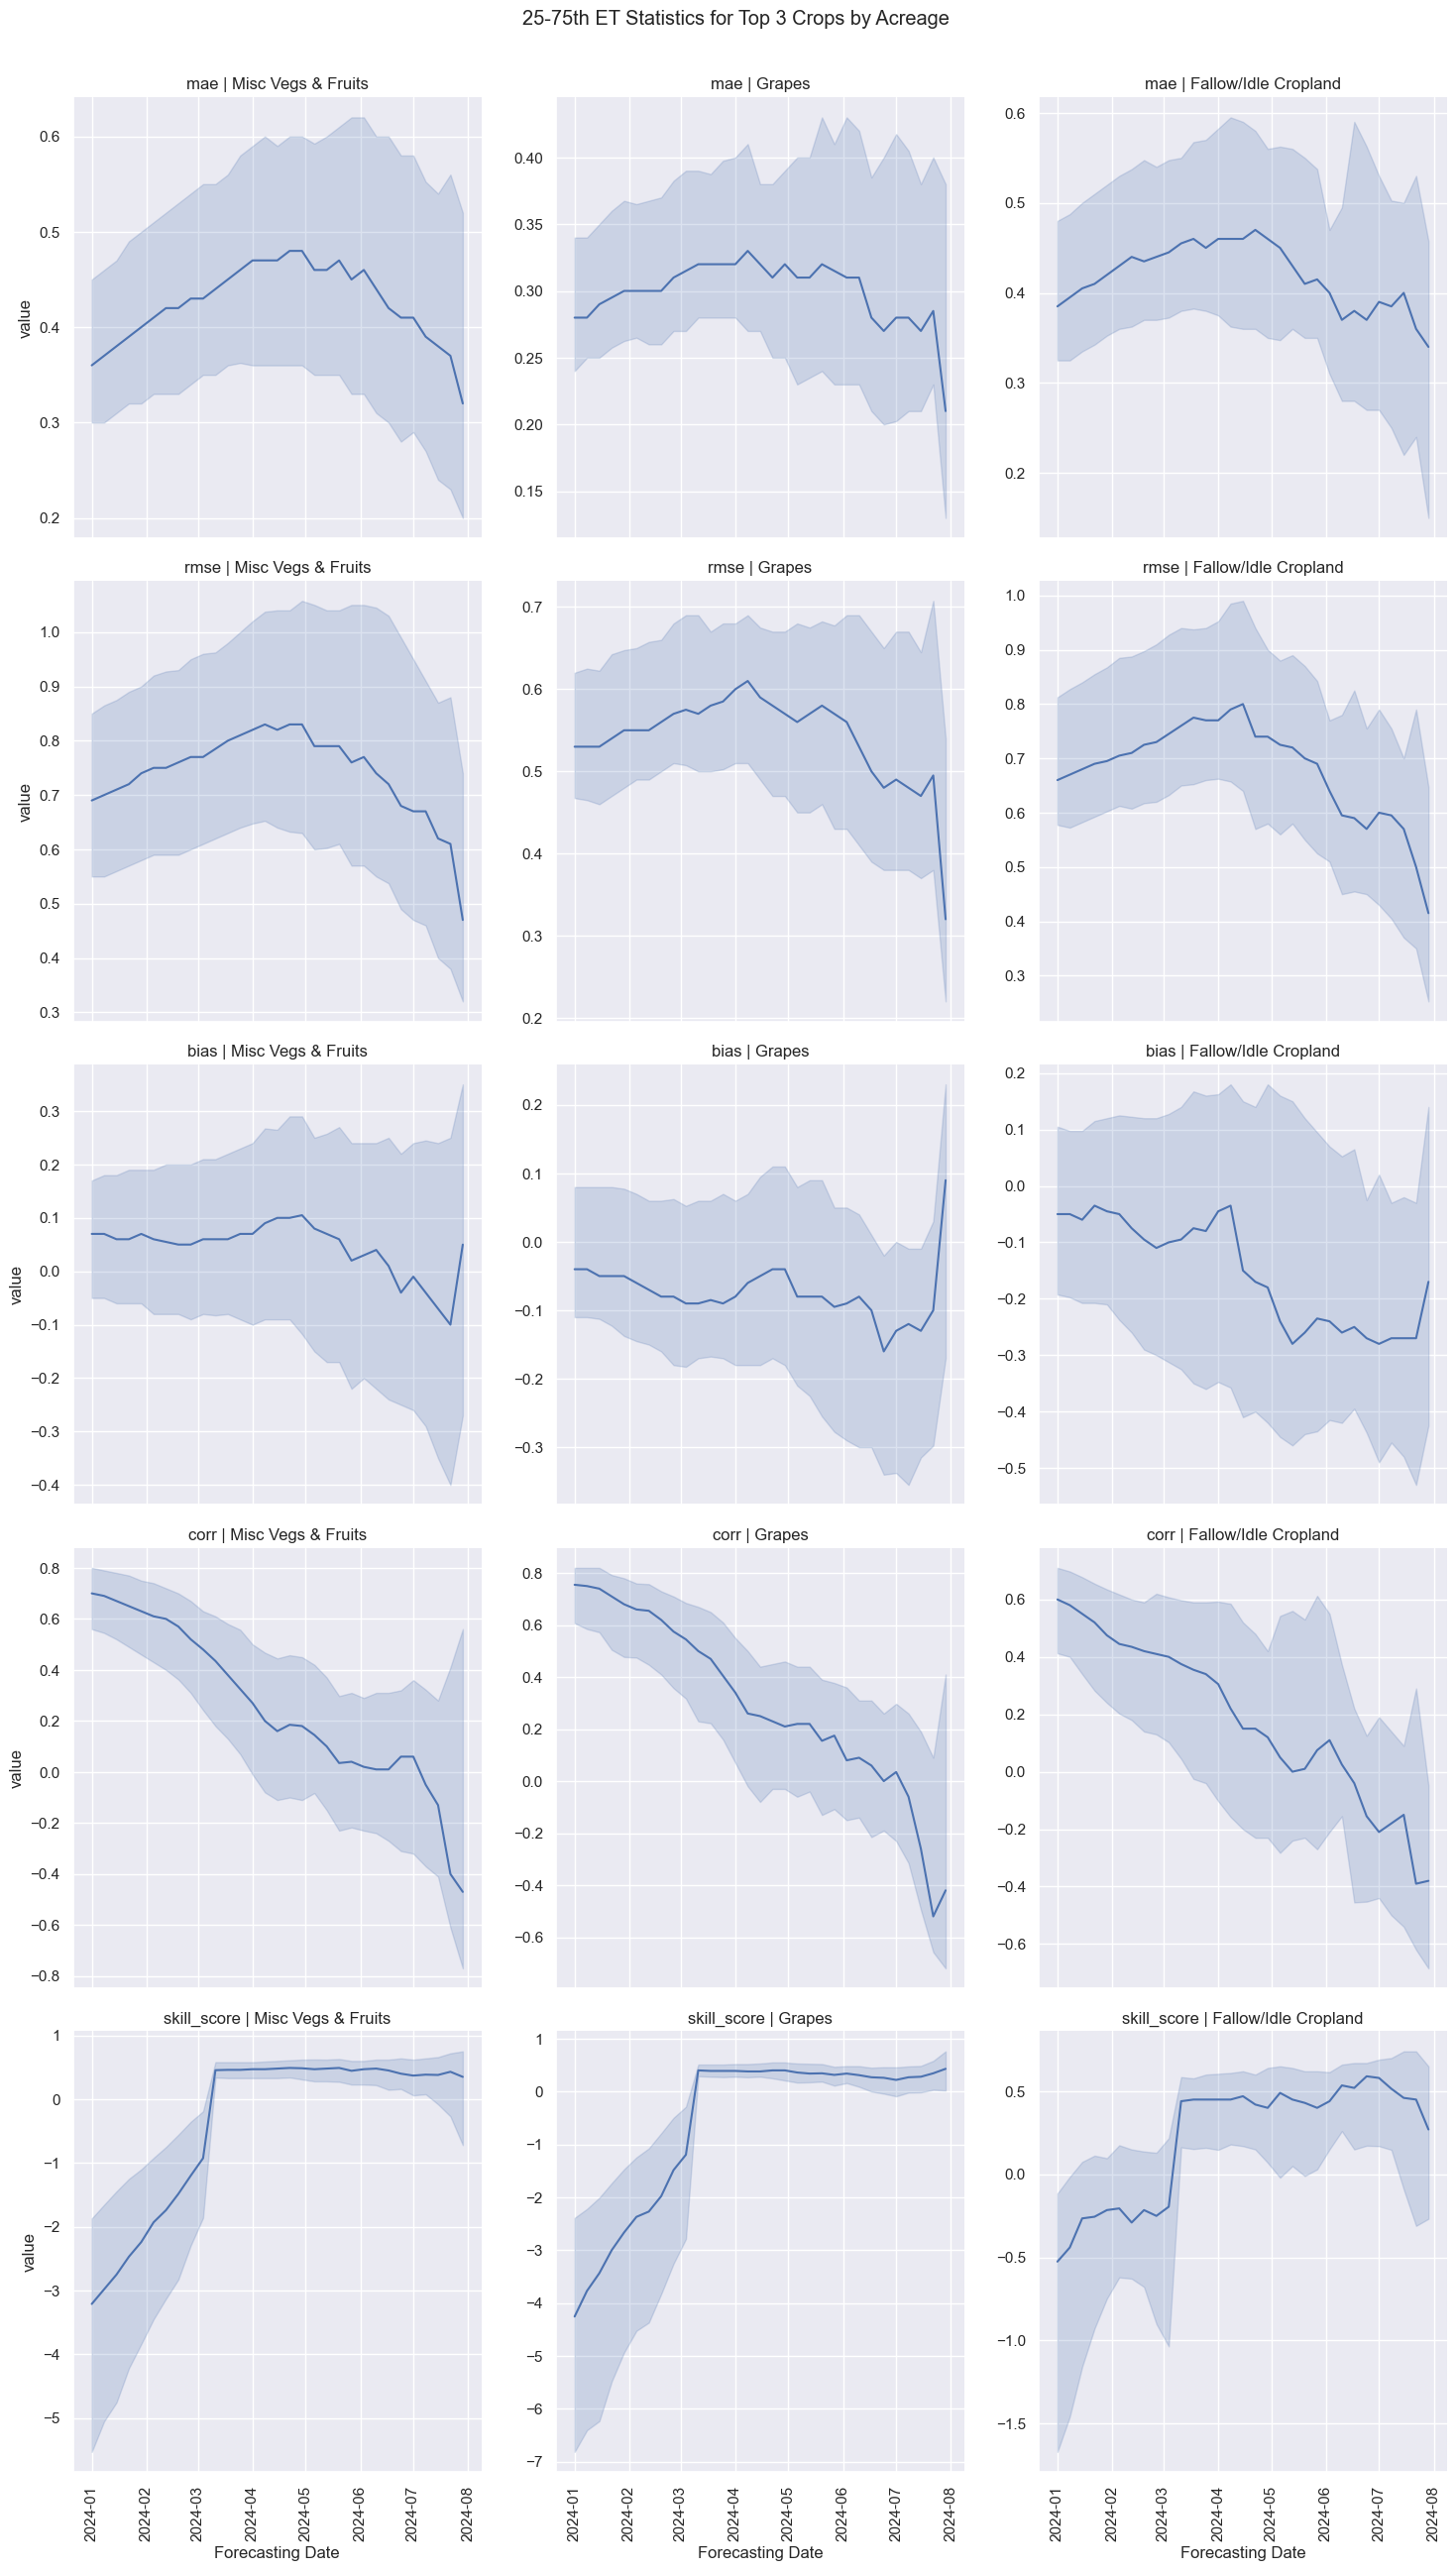

In [91]:
crop_dist_plot = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ET'], y='value', type='rel', kind='line', errorbar=('pi', 50),
               col='Class_Names', row='stat', facet_kws={'sharey': False, 'sharex': True}, estimator=np.median,
                               title='25-75th ET Statistics for Top 3 Crops by Acreage');
crop_dist_plot.set_titles(template="{row_name} | {col_name}");

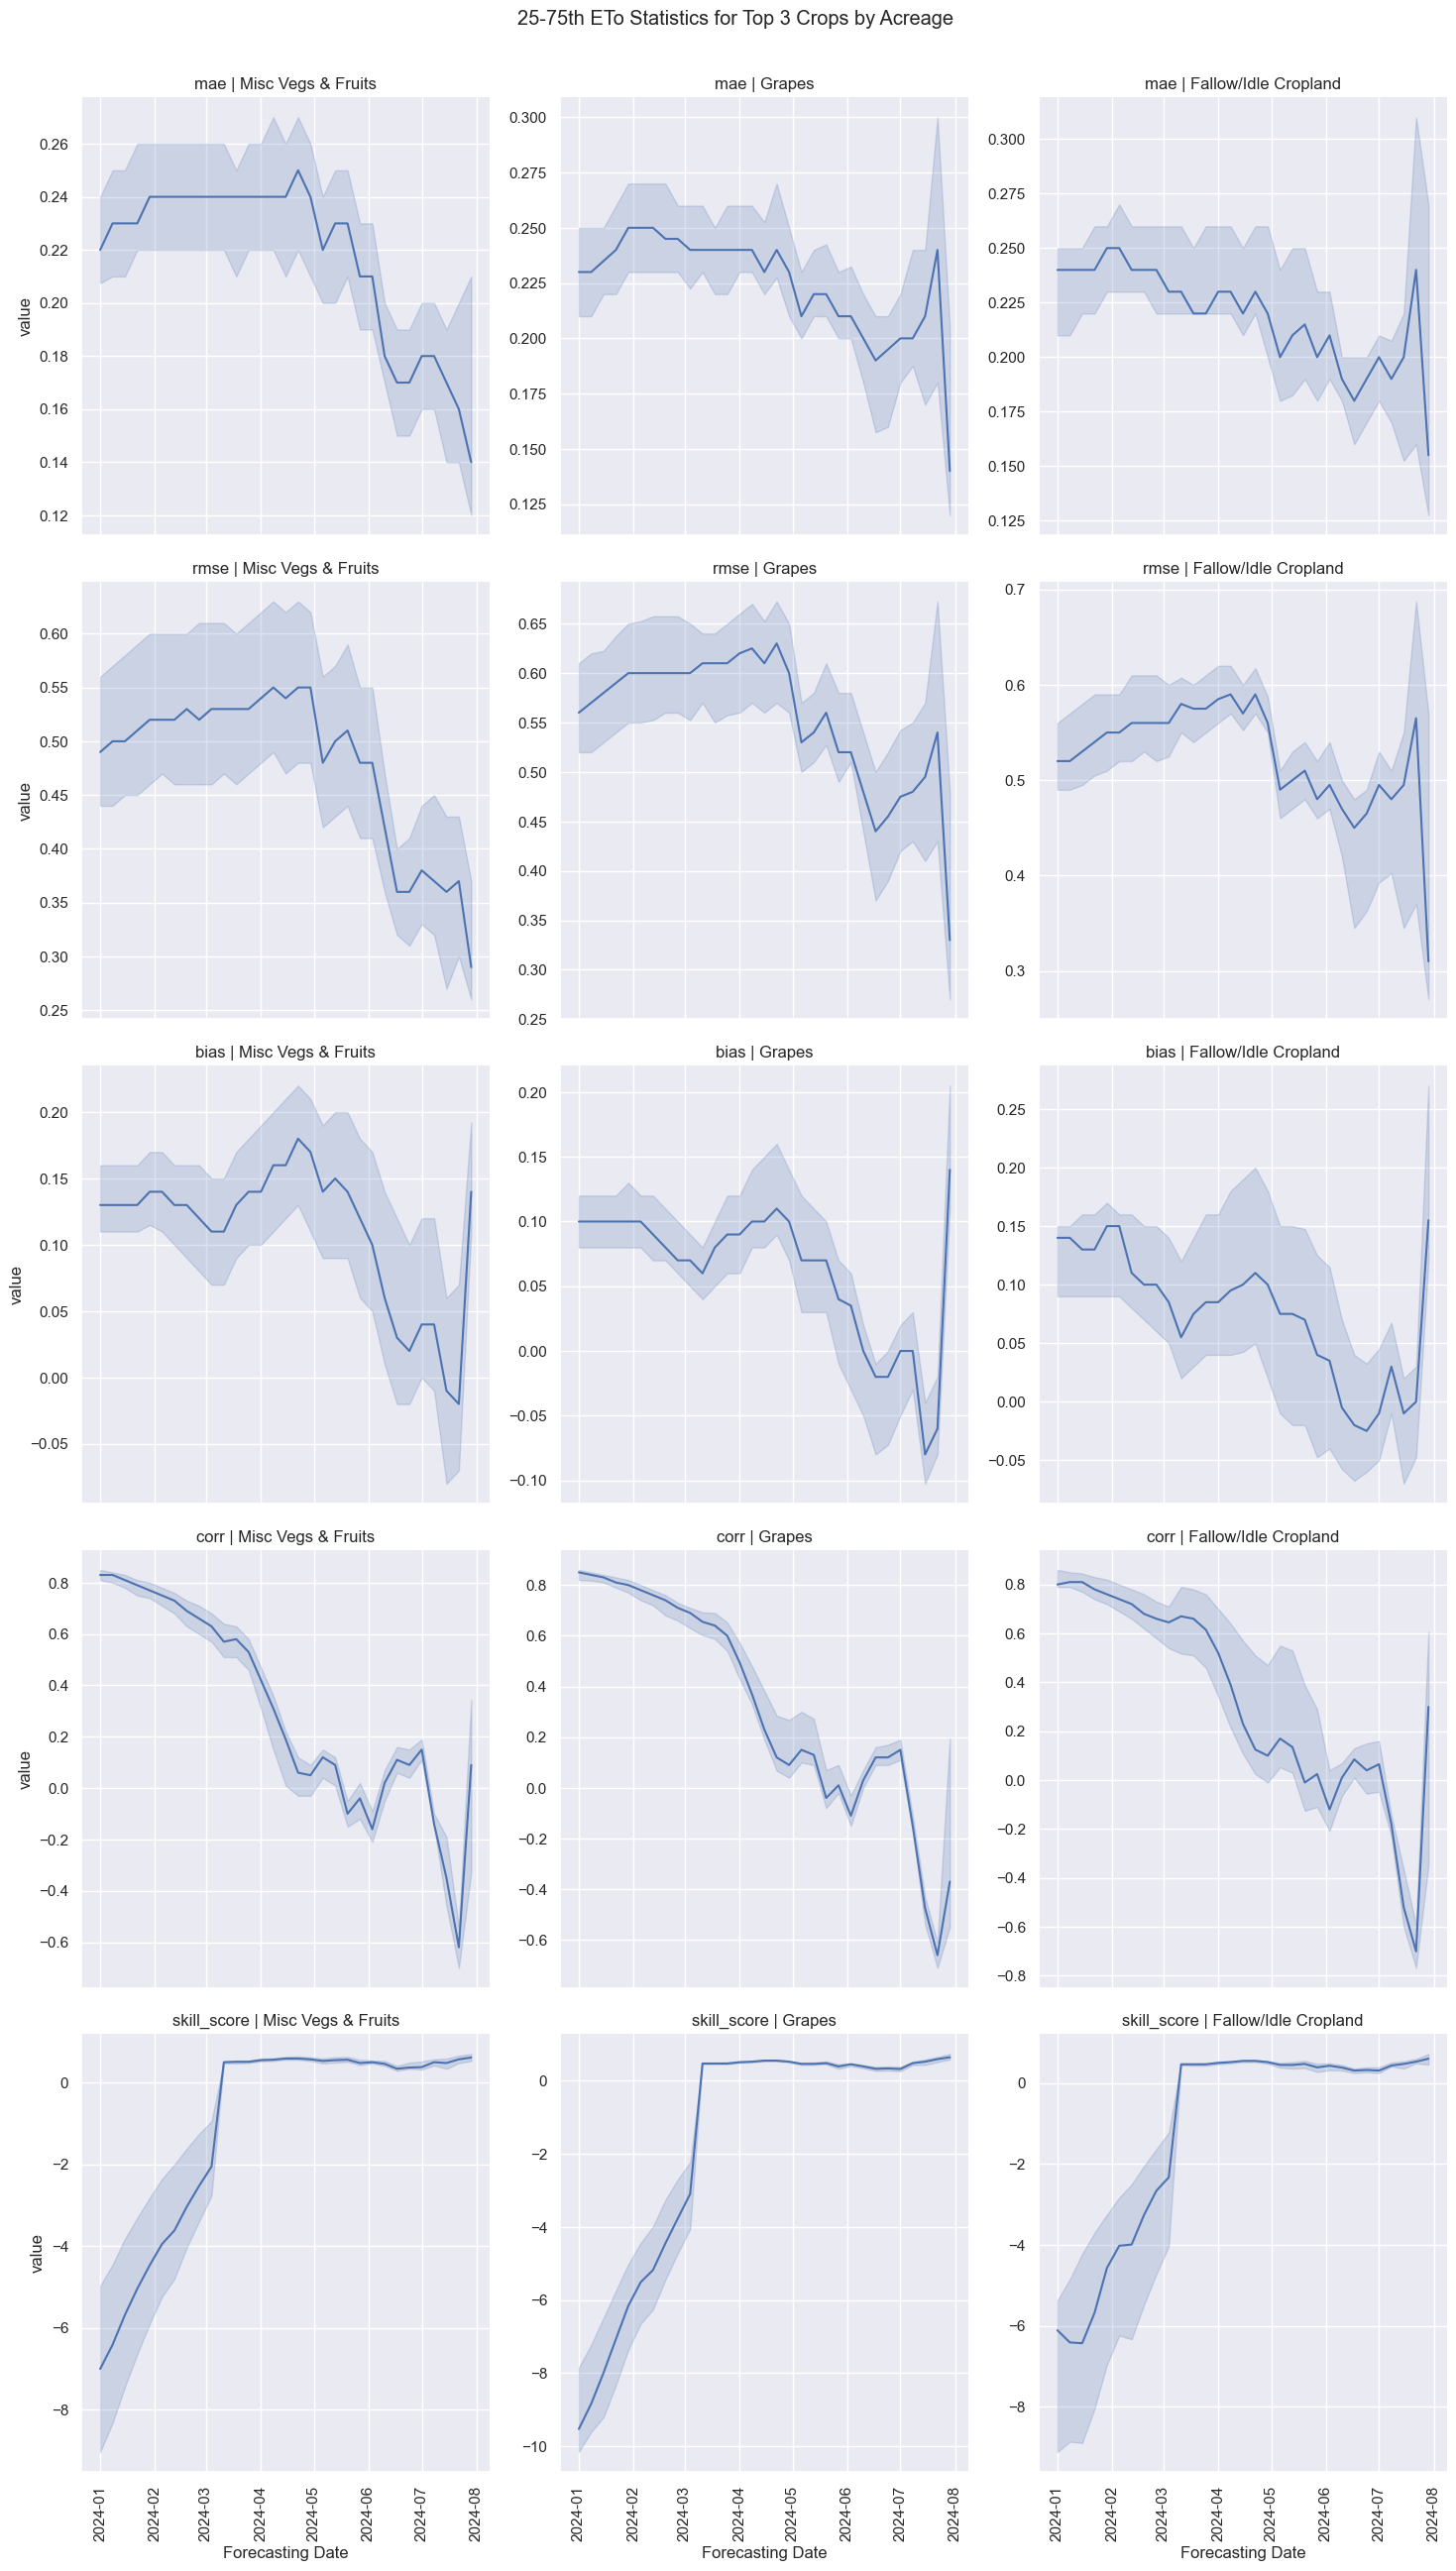

In [92]:
crop_dist_plot = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETo'], y='value', type='rel', kind='line', errorbar=('pi', 50),
               col='Class_Names', row='stat', facet_kws={'sharey': False, 'sharex': True}, estimator=np.median,
                               title='25-75th ETo Statistics for Top 3 Crops by Acreage');
crop_dist_plot.set_titles(template="{row_name} | {col_name}");

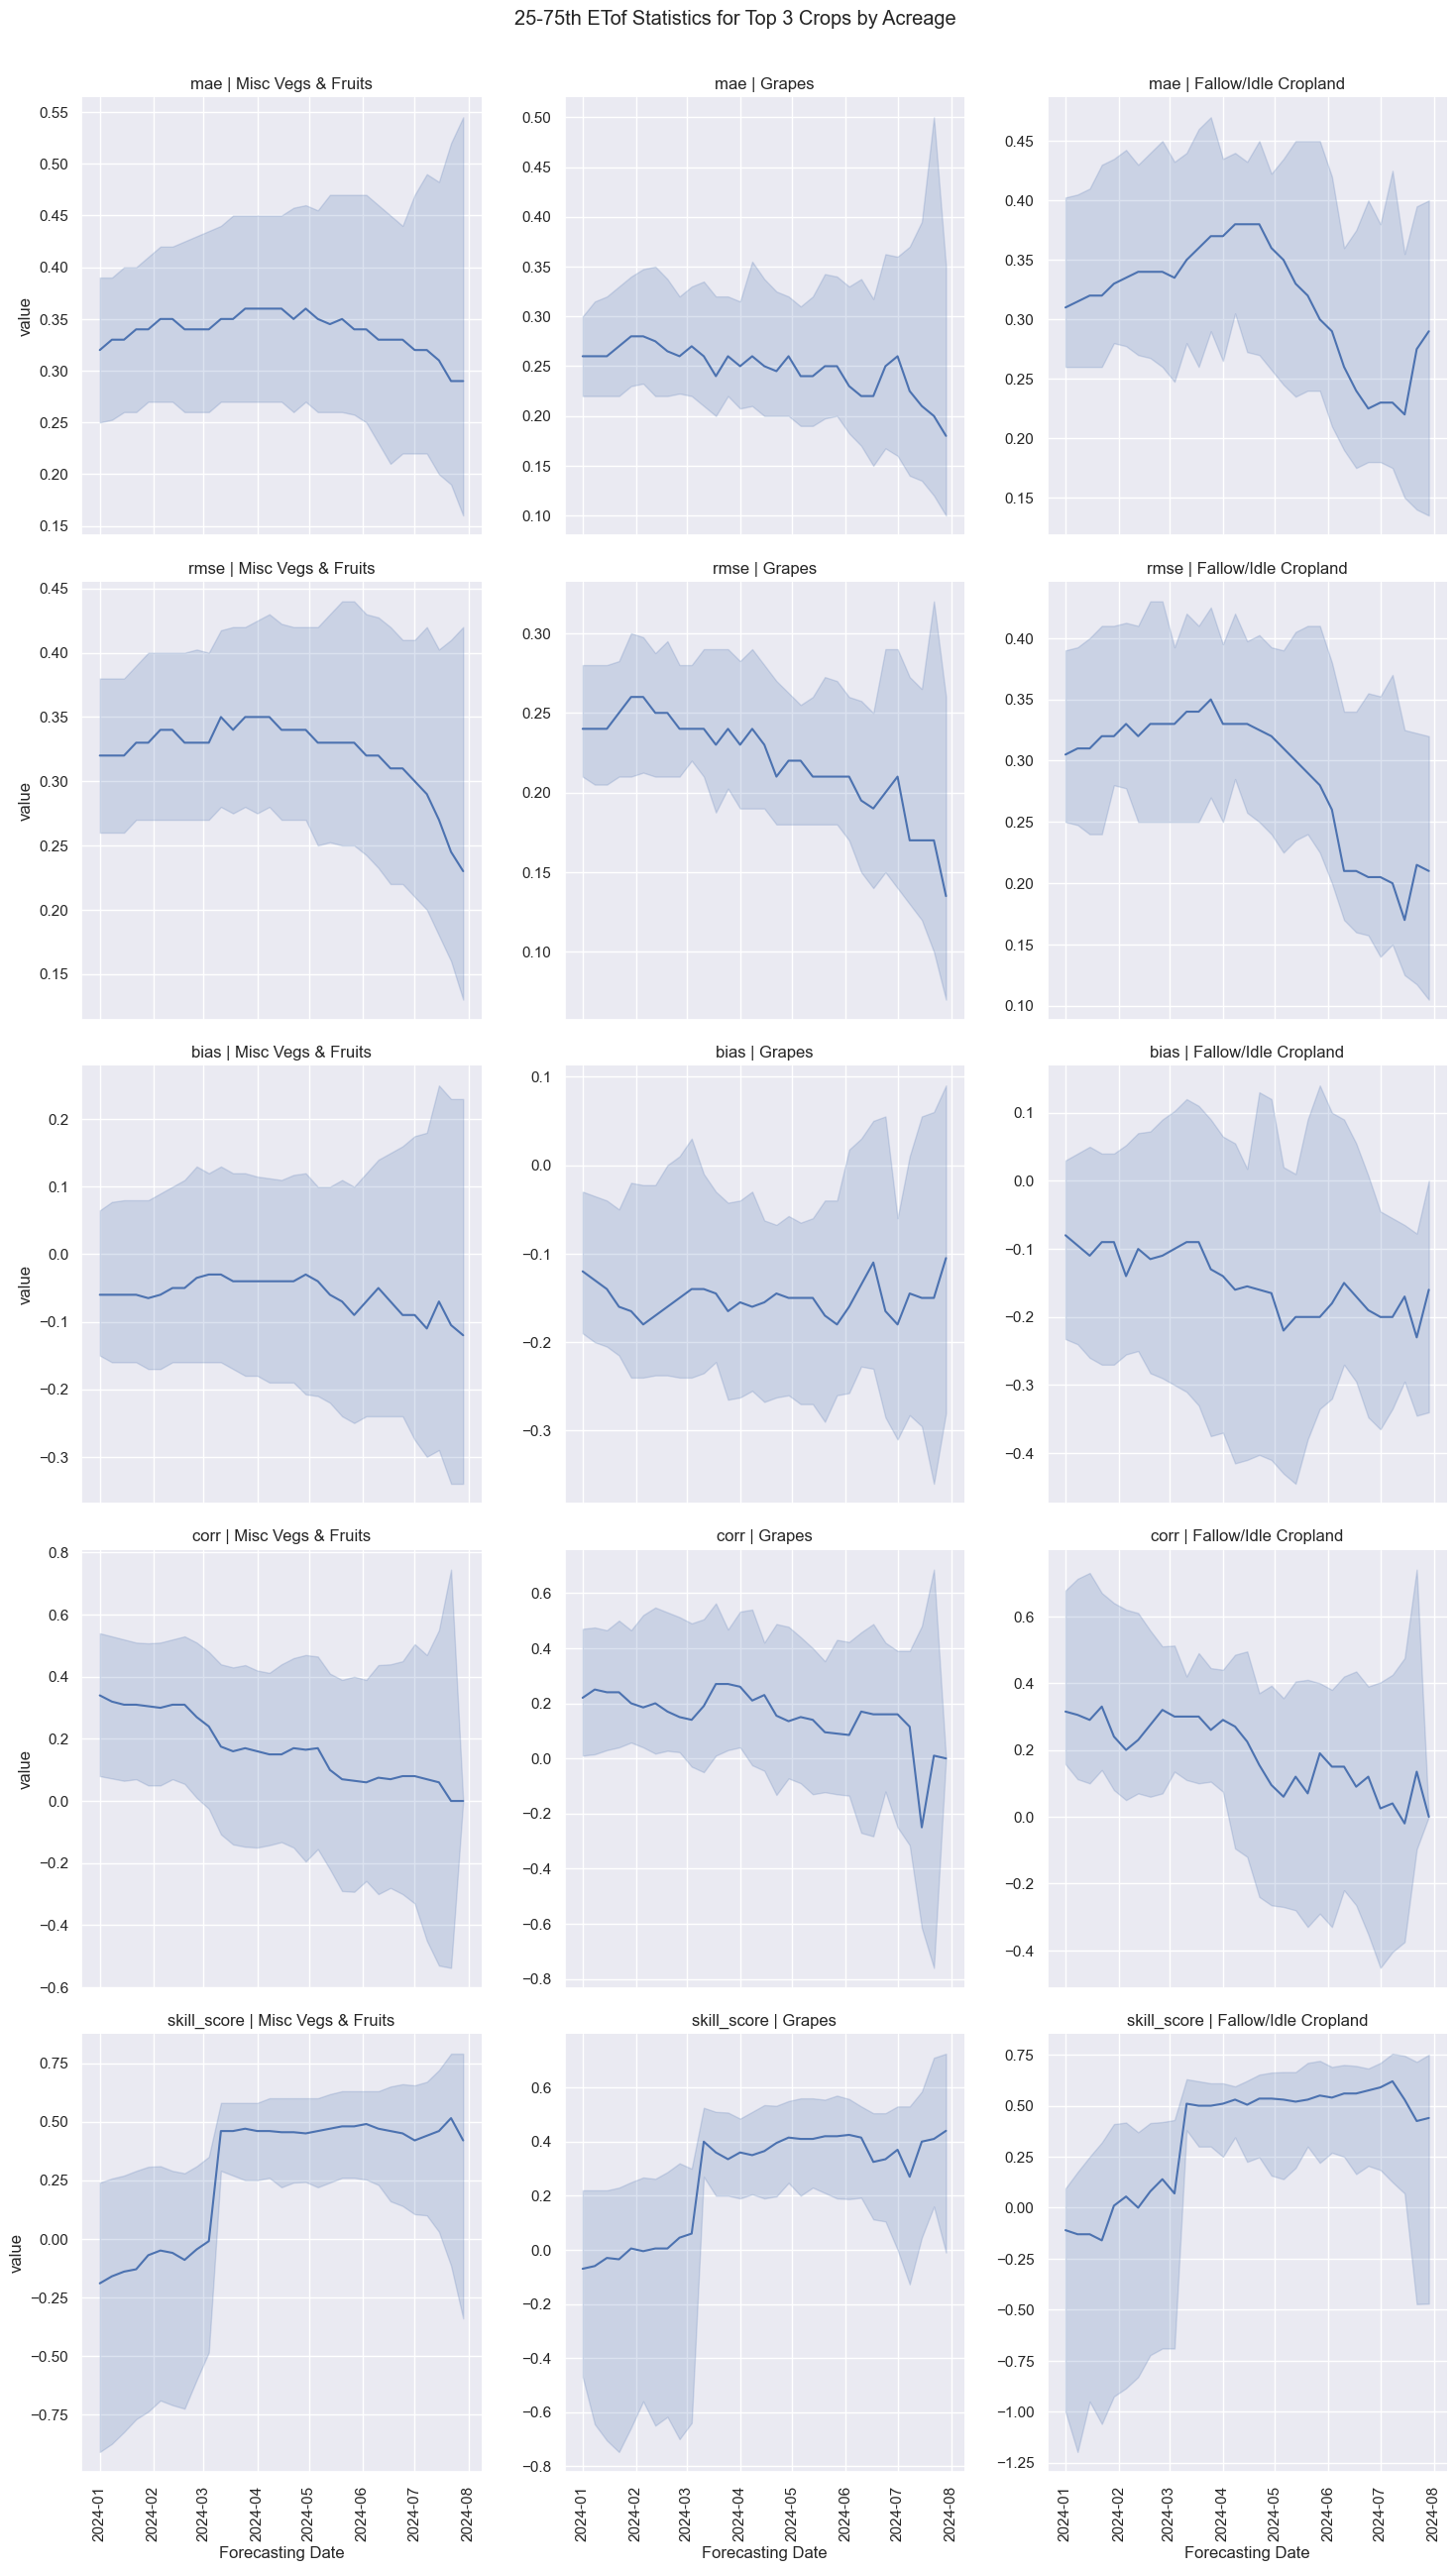

In [93]:
crop_dist_plot = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETof'], y='value', type='rel', kind='line', errorbar=('pi', 50),
               col='Class_Names', row='stat', facet_kws={'sharey': False, 'sharex': True}, estimator=np.median,
                               title='25-75th ETof Statistics for Top 3 Crops by Acreage');
crop_dist_plot.set_titles(template="{row_name} | {col_name}");

## Spatial Plotting

### Preparation

First merge the geo table created in the beginning with the metrics table.

Afterwards, get the average metrics amongst all forecasts.

In [50]:
# Define date range of seasons
winter = (datetime(year=2024, month=1, day=1), datetime(year=2024, month=3, day=20)) # Start winter at start of forecast range
spring = (datetime(year=2024, month=3, day=21), datetime(year=2024, month=6, day=20))
summer = (datetime(year=2024, month=6, day=21), datetime(year=2024, month=9, day=20))

# Create list of the forecast dates that fit the seasonal ranges
winter_forecasts = pd.Series([x for x in forecast_dates if x >= winter[0] and x <= winter[1]])
spring_forecasts = pd.Series([x for x in forecast_dates if x >= spring[0] and x <= spring[1]])
summer_forecasts = pd.Series([x for x in forecast_dates if x >= summer[0] and x <= summer[1]])

def assign_season(x):
    season = ""
    if winter_forecasts.isin([x['forecasting_date']]).any():
        season = "winter"
    elif spring_forecasts.isin([x['forecasting_date']]).any():
        season = "spring"
    elif summer_forecasts.isin([x['forecasting_date']]).any():
        season = "summer"
    return pd.Series({'season': season})

# Create column that defines a row's season
seasonal_metrics = metrics_norm.reset_index().merge(metrics_norm.reset_index().apply(assign_season, axis=1), left_index=True, right_index=True)

In [51]:
seasonal_metrics = seasonal_metrics.groupby(['field_id', 'season'])[['mae', 'rmse', 'bias', 'corr', 'skill_score']].agg('mean').round(2)
seasonal_metrics = seasonal_metrics.join(monterey_geo, how='left', on='field_id', validate='many_to_one')
seasonal_metrics.reset_index(inplace=True)
seasonal_metrics

,field_id,season,mae,rmse,bias,corr,skill_score,longitude,latitude
0,CA_244000,spring,0.34,0.46,-0.06,-0.08,0.55,-121.540540,36.537255
1,CA_244000,summer,0.39,0.51,-0.30,-0.02,0.53,-121.540540,36.537255
2,CA_244000,winter,0.43,0.81,0.00,0.26,-1.50,-121.540540,36.537255
3,CA_244018,spring,0.48,0.65,0.09,-0.22,0.56,-121.539709,36.547528
4,CA_244018,summer,0.42,0.52,0.36,-0.17,0.20,-121.539709,36.547528
...,...,...,...,...,...,...,...,...,...
2212,CA_420910,summer,0.31,0.47,-0.22,-0.14,-0.06,-121.055115,35.811932
2213,CA_420910,winter,0.36,0.58,-0.27,0.60,-0.27,-121.055115,35.811932
2214,CA_420924,spring,0.20,0.40,0.07,0.10,0.40,-121.721861,36.894001
2215,CA_420924,summer,0.14,0.27,-0.02,-0.18,0.37,-121.721861,36.894001


### Import regional polygon

In [52]:
moco_geo = gpd.read_file("./data/geo/MoCo_Boundary.geojson")
moco_geo

,FID,PERIMETER,COUNTY,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1903900,MONTEREY CO,9.239835e+10,2.155890e+06,"POLYGON ((-121.69858 36.9167, -121.70104 36.91..."


### Seasonal Overview

#### FacetGrid Geo Helper

In [111]:
def facet_geoscatter(data, *, boundary_map, col, hue, palette="YlOrRd", height=4, aspect=1.2):
    g = sns.FacetGrid(data, col=col, height=height, aspect=aspect)
    for ax in g.axes.flat:
     boundary_map.plot(color="lightgrey", ax=ax)
    g.map_dataframe(sns.scatterplot, x="longitude", y="latitude", hue=hue, palette=palette, linewidths=0, s=8);

    g.fig.subplots_adjust(right=.92)
    g.tick_params(axis='x', rotation=90)
    cax = g.fig.add_axes([.94, .25, .02, .6])
    points = plt.scatter([], [], c=[], vmin=data[hue].min(), vmax=data[hue].max(), cmap=palette);
    g.fig.colorbar(points, cax=cax);

    return g

#### Visualization

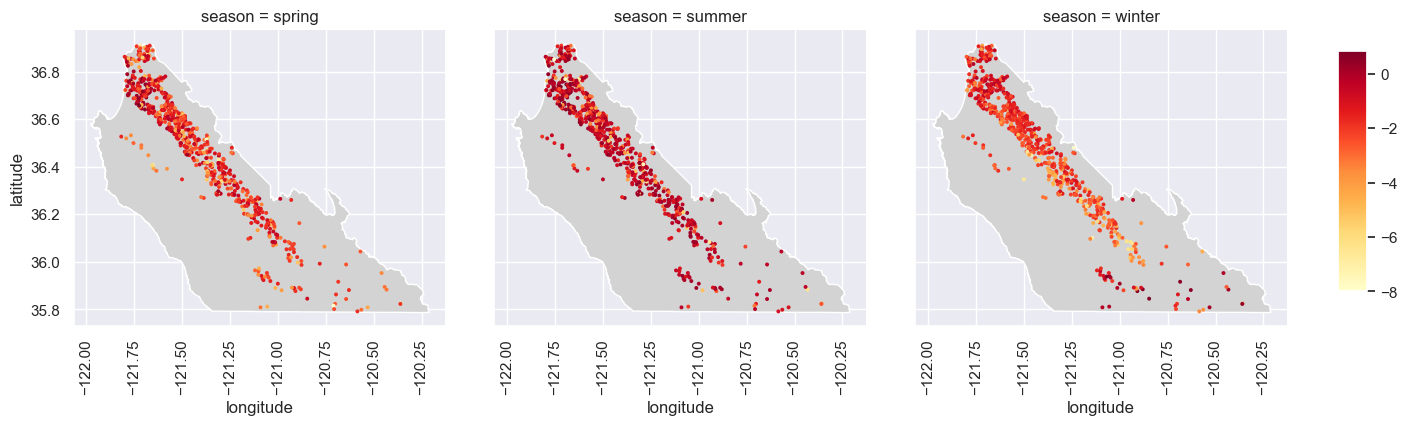

In [112]:
facet_geoscatter(seasonal_metrics, boundary_map=moco_geo, col='season', hue='skill_score');

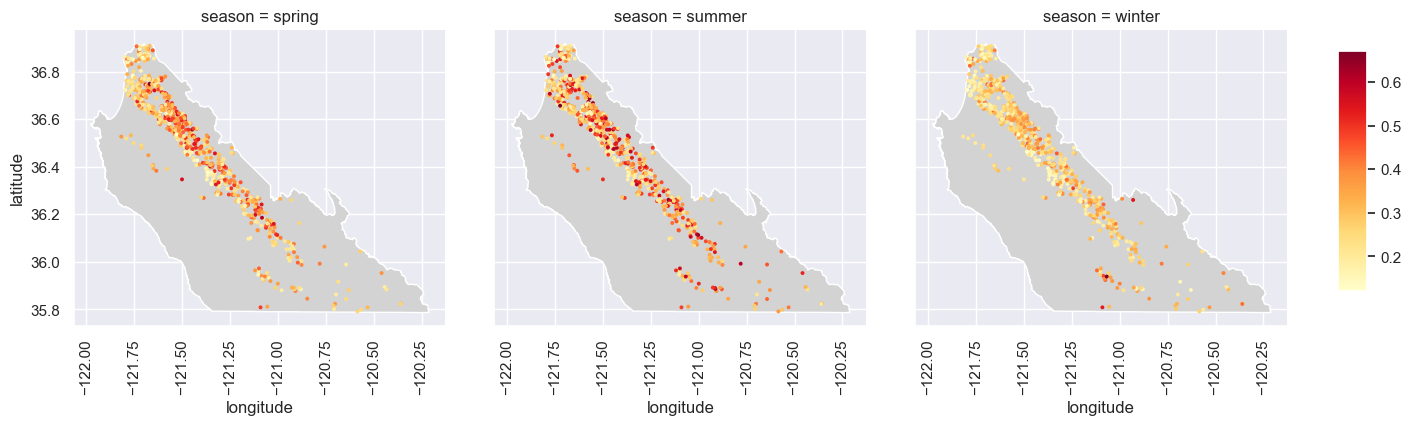

In [113]:
facet_geoscatter(seasonal_metrics, boundary_map=moco_geo, col='season', hue='mae');

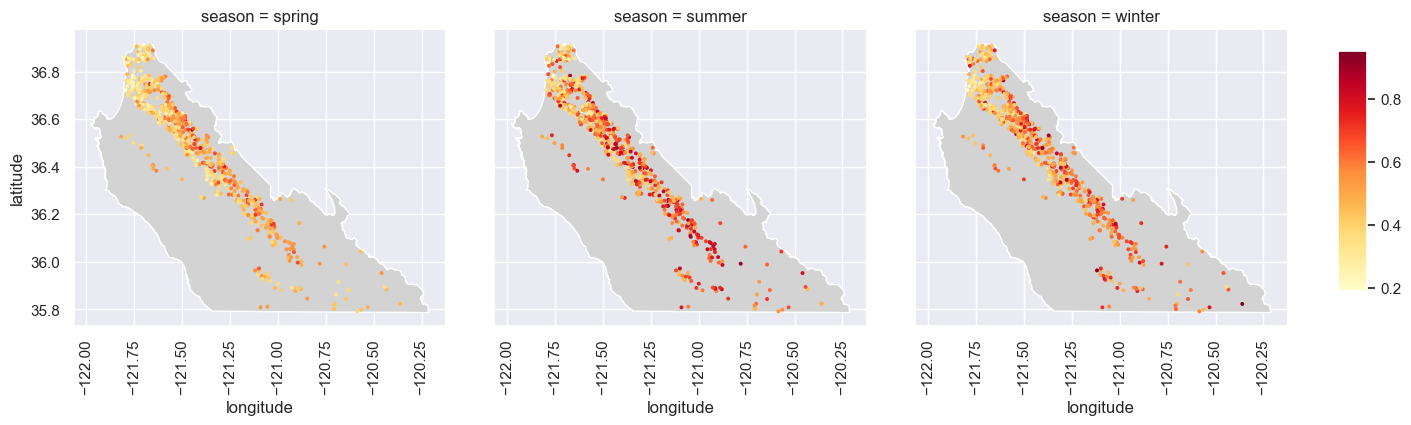

In [114]:
facet_geoscatter(seasonal_metrics, boundary_map=moco_geo, col='season', hue='rmse');

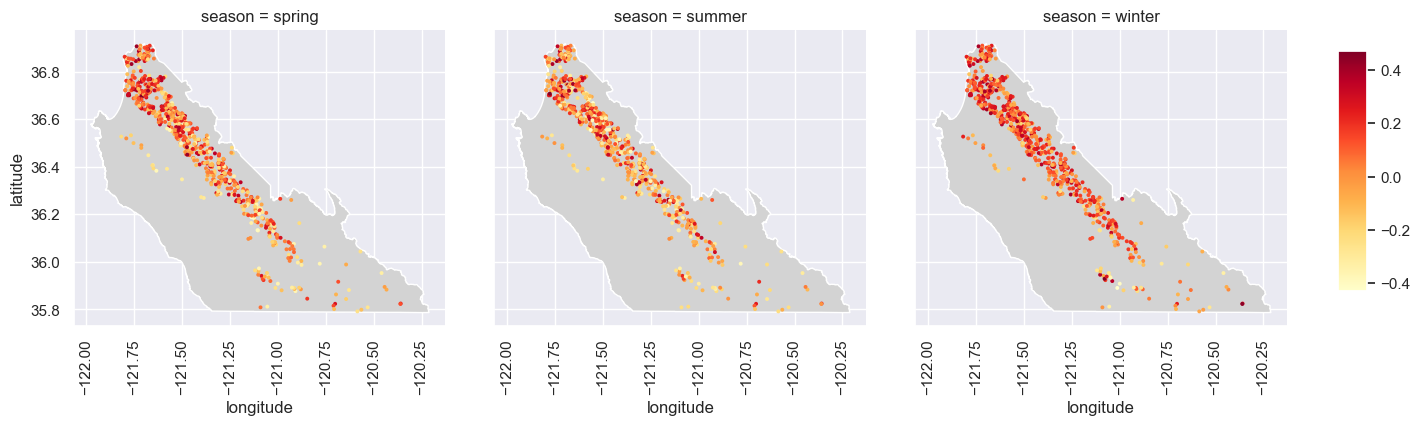

In [115]:
facet_geoscatter(seasonal_metrics, boundary_map=moco_geo, col='season', hue='bias');

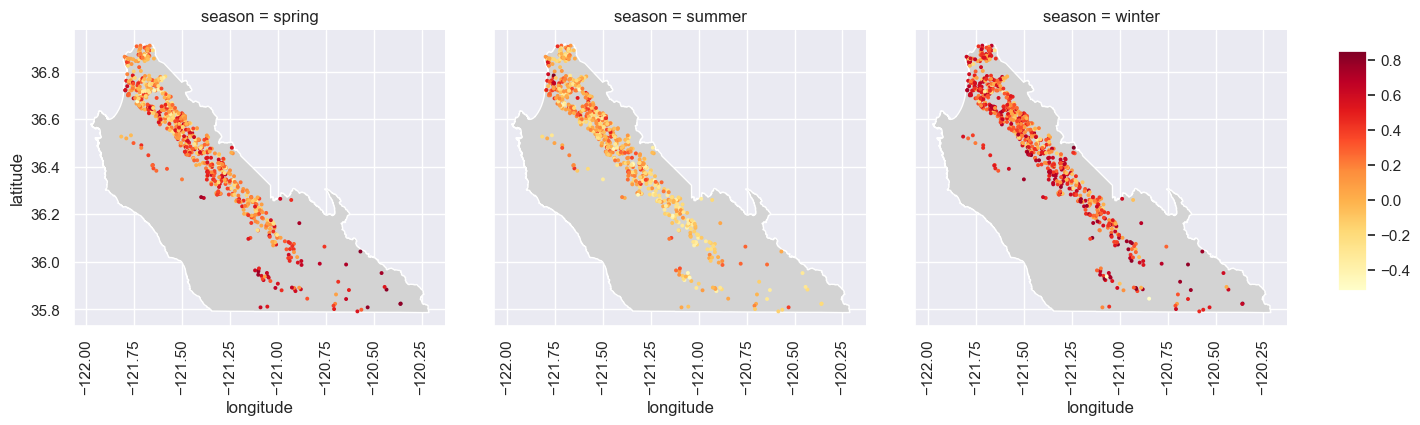

In [116]:
facet_geoscatter(seasonal_metrics, boundary_map=moco_geo, col='season', hue='corr');